In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [42]:
def Rastrigin_function(
    x: np.array,
    n: int = 2,
    A: float = 10,
) -> np.array:

    y = A * n + x[0]**2 - A * np.cos(2 * np.pi * x[0]) + x[1]**2 - A * np.cos(2 * np.pi * x[1]) 
    return y

def Rastrigin_gradient(
    x: np.array,
    n: int = 2,
    A: float = 10,
) -> np.array:
    
    df_dx = 2 * x[0] + 2 * np.pi * A * np.sin(2 * np.pi * x[0])
    df_dy = 2 * x[1] + 2 * np.pi * A * np.sin(2 * np.pi * x[1])
    return np.array([df_dx, df_dy])

In [43]:
def sphere_function(
    x: np.array,
    A: float = 1,
    B: float = 1,
) -> np.array:

    y = A * x[0]**2 + B * x[1]**2
    return y

def sphere_gradient(
    x: np.array,
    A: float = 1,
    B: float = 1,
) -> np.array:
    
    df_dx = 2 * A * x[0]
    df_dy = 2 * B * x[1]
    return np.array([df_dx, df_dy])

In [44]:
X = np.arange(-1, 1, 0.5)
Y = np.arange(-1, 1, 0.5)
x = np.meshgrid(X, Y)

In [39]:
x

(array([[-1. , -0.5,  0. ,  0.5],
        [-1. , -0.5,  0. ,  0.5],
        [-1. , -0.5,  0. ,  0.5],
        [-1. , -0.5,  0. ,  0.5]]),
 array([[-1. , -1. , -1. , -1. ],
        [-0.5, -0.5, -0.5, -0.5],
        [ 0. ,  0. ,  0. ,  0. ],
        [ 0.5,  0.5,  0.5,  0.5]]))

In [50]:
def plot_function(
    function: callable,
    xlim: tuple = (-5, 5),
    ylim: tuple = (-5, 5),
    step: float = 0.05,
    flat: bool = True,
):

    x1 = np.arange(xlim[0], xlim[1], step)
    x2 = np.arange(ylim[0], ylim[1], step)
    x = np.meshgrid(x1, x2)

    y = function(x)


    if flat:
        fig, ax = plt.subplots()
        im = ax.imshow(y, extent=[xlim[0], xlim[1], ylim[0], ylim[1]],
           origin='lower', cmap='viridis', aspect='equal')
        
        fig.colorbar(im, ax=ax, shrink=0.5, aspect=5)

    else:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection="3d")

        surf = ax.plot_surface(
            x[0], x[1], y,
            facecolors=plt.cm.viridis(y), 
            rstride=1, cstride=1
        )

        fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
        plt.show()

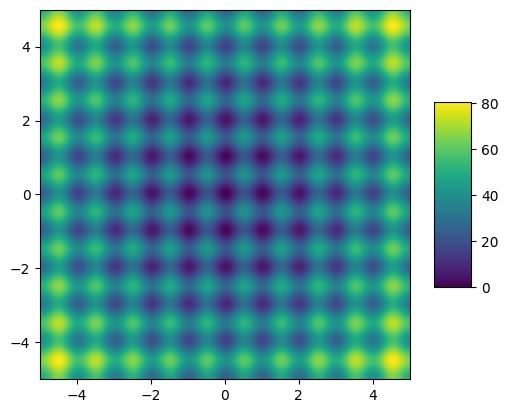

In [51]:
%matplotlib inline

plot_function(Rastrigin_function)

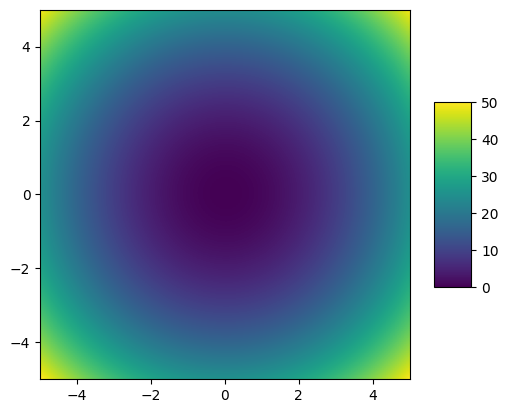

In [52]:
plot_function(sphere_function)

In [74]:
class GradientOptimizer:
    def __init__(
        self,
        function: callable,
        grad_function: callable = None,
        grad_calculation: str = '',
        stop_criteria: str = 'point_norm',
        max_iteration: int = 100,
        alpha: float = 1e-1,
        eps: float = 1e-2,
    ):

        self.function = function
        self.grad_function = grad_function
        self.grad_calculation = grad_calculation
        self.stop_criteria = stop_criteria
        self.max_iteration = max_iteration
        self.alpha = alpha
        self.eps = eps

    def step(self, current_point):
        grad = self.grad_function(current_point)
        next_point = current_point - self.alpha * grad
        next_value = self.function(next_point)

        if self.stop_criteria == 'point_norm':
            done = np.linalg.norm(current_point - next_point) < self.eps

        return next_point, next_value, done


    def find_minimum(self, initial_point):
        if self.grad_function is None:
            pass

        point_seq = []
        value_seq = []
        point_seq.append(initial_point)
        value_seq.append(self.function(initial_point))

        for _ in range(self.max_iteration):
            next_point, next_value, done = self.step(point_seq[-1])
            point_seq.append(next_point)
            value_seq.append(next_value)
            if done:
                break

        return point_seq, value_seq

In [75]:
optimizer = GradientOptimizer(sphere_function, sphere_gradient)

In [76]:
x_0 = np.array([-3, 3])
x_seq, y_seq = optimizer.find_minimum(x_0)

In [77]:
len(x_seq)

22

In [78]:
x_seq

[array([-3,  3]),
 array([-2.4,  2.4]),
 array([-1.92,  1.92]),
 array([-1.536,  1.536]),
 array([-1.2288,  1.2288]),
 array([-0.98304,  0.98304]),
 array([-0.786432,  0.786432]),
 array([-0.6291456,  0.6291456]),
 array([-0.50331648,  0.50331648]),
 array([-0.40265318,  0.40265318]),
 array([-0.32212255,  0.32212255]),
 array([-0.25769804,  0.25769804]),
 array([-0.20615843,  0.20615843]),
 array([-0.16492674,  0.16492674]),
 array([-0.1319414,  0.1319414]),
 array([-0.10555312,  0.10555312]),
 array([-0.08444249,  0.08444249]),
 array([-0.06755399,  0.06755399]),
 array([-0.0540432,  0.0540432]),
 array([-0.04323456,  0.04323456]),
 array([-0.03458765,  0.03458765]),
 array([-0.02767012,  0.02767012])]